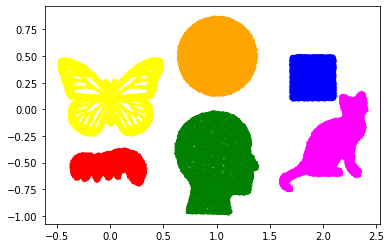

In [4]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

In [5]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2).to(device); 
outfolder = "results/experiment1/"
# model.load_state("results/experiment1/models/state_final.tar")
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 101, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)

  1%|          | 1/101 [00:01<01:44,  1.05s/it]

Allocated: 0.03 GB  Reserved: 0.51 GB
(loss: 1.4142) (lr: 0.0001) (n_subsample: 300) 
(time elapsed: 1.0476) (total time: 1.0493) (fit time: 0.1575) (reg loss time: 0.1049) (savetime: 0.0000) (steptime: 0.7833)


 21%|██        | 21/101 [00:36<06:02,  4.53s/it]

Allocated: 0.03 GB  Reserved: 0.52 GB
(loss: 0.8844) (lr: 0.0001) (n_subsample: 300) 
(time elapsed: 25.1976) (total time: 36.8820) (fit time: 0.2234) (reg loss time: 0.1306) (savetime: 10.6311) (steptime: 0.9620)


 41%|████      | 41/101 [01:18<04:48,  4.80s/it]

Allocated: 0.03 GB  Reserved: 0.52 GB
(loss: 0.4917) (lr: 0.0001) (n_subsample: 300) 
(time elapsed: 31.4425) (total time: 78.8842) (fit time: 0.2562) (reg loss time: 0.2069) (savetime: 10.5565) (steptime: 1.2397)


 60%|██████    | 61/101 [02:02<03:12,  4.81s/it]

Allocated: 0.03 GB  Reserved: 0.52 GB
(loss: 0.2112) (lr: 0.0001) (n_subsample: 378) 
(time elapsed: 32.9726) (total time: 122.4267) (fit time: 0.2798) (reg loss time: 0.1896) (savetime: 10.5654) (steptime: 1.2446)


 80%|████████  | 81/101 [02:45<01:35,  4.77s/it]

Allocated: 0.03 GB  Reserved: 0.52 GB
(loss: 0.0755) (lr: 0.0001) (n_subsample: 378) 
(time elapsed: 32.7820) (total time: 165.7817) (fit time: 0.2519) (reg loss time: 0.2027) (savetime: 10.5695) (steptime: 1.1215)


100%|██████████| 101/101 [03:28<00:00,  2.06s/it]

Allocated: 0.03 GB  Reserved: 0.52 GB
(loss: 0.0509) (lr: 0.0001) (n_subsample: 476) 
(time elapsed: 32.0200) (total time: 208.5358) (fit time: 0.2460) (reg loss time: 0.1414) (savetime: 10.7298) (steptime: 1.0509)


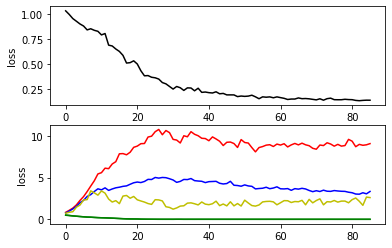

In [208]:
# separate_losses = separate_times
start=15;end=600;
(fig,(ax1,ax2))=plt.subplots(2,1)
ax1.plot(losses[start:end],'k'); ax1.set_ylabel('loss') 
ax2.plot(separate_losses[0,start:end],'g'); 
ax2.plot(separate_losses[1,start:end],'g'); 
ax2.plot(separate_losses[9,start:end],'r'); 
ax2.plot(separate_losses[10,start:end],'b'); 
ax2.plot(separate_losses[3,start:end],'y'); ax2.set_ylabel('loss') 
plt.savefig(outfolder + "losses.pdf"); 